In [42]:
import pandas as pd
import igraph
import numpy as np
import pdb
from ndex2.nice_cx_network import NiceCXNetwork
import ndex2.client as nc
import ndex2
import networkx as nx
from fa2 import ForceAtlas2

#from https://github.com/idekerlab/cy-rest-R/blob/develop/workflow1_structure_based_visualization.R

# Step 1: Network Data Preparation

Load network from NDEx

In [43]:
nice_cx_network = ndex2.create_nice_cx_from_server(server='public.ndexbio.org', uuid='c060aff9-86d4-11e7-a10d-0ac135e8bacf')
# nice_cx_network = ndex2.create_nice_cx_from_server(server='public.ndexbio.org', uuid='f1dd6cc3-0007-11e6-b550-06603eb7f303')
# nice_cx_network =  ndex2.create_nice_cx_from_server(server='public.ndexbio.org', uuid='ff8e7def-6e09-11e9-848d-0ac135e8bacf')

In [44]:
nice_cx_network.print_summary()

Name: BioPlex
Nodes: 10961
Edges: 56553
Node Attributes: 0
Edge Attributes: 0



In [45]:
nice_cx_from_server_df=nice_cx_network.to_pandas_dataframe()

In [46]:
nice_cx_from_server_df.head()

,source,interaction,target
0,UBE2Q1,None,SRPRB
1,UBE2Q1,None,LYPD3
2,UBE2Q1,None,C1QTNF2
3,UBE2Q1,None,C3AR1
4,UBE2Q1,None,TCEAL1


Convert it to simple edge list

In [47]:
edgelist=nice_cx_from_server_df.iloc[:,[0,2]]

Convert DF to undirected igraph object
This is a PPI network, so import as undirected.

In [48]:
tuples=[tuple(x) for x in edgelist.values]
g_original = igraph.Graph.TupleList(tuples,directed=False)

Extract componentes (individual connected subgraphs)

In [49]:
subgraphs=g_original.decompose()

Pick largest subgraph

In [50]:
tmp=[i.vcount() for i in subgraphs]
largeset_subgraph = subgraphs[tmp.index(max(tmp))]

Remove duplicate edges

In [51]:
g = largeset_subgraph.simplify(multiple=True, loops=True)
g.name = "Yeast network"

# Step 2: Basic statistical analysis

Global Network Statics

In [52]:
print("Density:",g.density())
print("Transitivity:",g.transitivity_undirected())

Density: 0.0009513309527195972
Transitivity: 0.06052352935506834


Node statistics

In [53]:
g_closeness = g.vs.closeness() # Closeness Centrarity
g_degree = g.vs.degree() # Degree
g_pagerank = g.vs.pagerank(directed = False) # PageRank
g_vs_betweenness = g.vs.betweenness() # Betweenness Centrarity

Edge statics

In [54]:
g_es_betweenness = g.es.edge_betweenness() # Edge Betweenness

# Step 3: Community Detection: Try multiple algorithms

Clustering

In [55]:
communities_greedy = g.community_fastgreedy().as_clustering()
communities_leading = g.community_leading_eigenvector()
communities_label_propagation = g.community_label_propagation()

In [56]:
v_community_greedy = communities_greedy.membership
v_community_leading = communities_leading.membership
v_community_label_propagation = communities_label_propagation.membership

In [57]:
def getCommunityEdge(g, community):
    num_edges = g.ecount()
    edge_community = [-1]*num_edges
    comms = community
    sources=[i for i, _ in g.get_edgelist()]
    targets=[j for _, j in g.get_edgelist()]
    for i in range(num_edges):
        sidx = sources[i]
        tidx = targets[i]
        source = comms[sidx]
        target = comms[tidx]
        
        if source == target:
            edge_community[i] = source
    return edge_community
    

In [58]:
e_commnity_greedy = getCommunityEdge(g, v_community_greedy)
e_commnity_leading = getCommunityEdge(g, v_community_leading)
e_community_label_propagation = getCommunityEdge(g, v_community_label_propagation)

## Community to Colors

In [59]:
import seaborn as sns

In [60]:
def communityToColors(members):
    basecolor='#AAAAAA'
    num_members=len(members)
    num_communities=max(members)+1
    colors = [basecolor]*num_members
    
    colorp = sns.color_palette("hls", num_communities)
    
#     sns.palplot(colorp)
    
    #print(num_communities,num_members)
    colorpalette=[rgb2hex(int(a[0]*255),int(a[1]*255),int(a[2]*255)) for a in colorp]
    
    for i in range(num_members):
        newcolor = colorpalette[members[i]]
        if( members[i] == -1 ):
            newcolor = basecolor
        colors[i] = newcolor
    return colors

def rgb2hex(r,g,b): #RGB配列からHTMLなどに使われる16進数表現へ
    # r , g , b = 0 〜 255 # int型
    color = (r, g , b)
    html_color = '#%02X%02X%02X' % (color[0],color[1],color[2])
    return html_color


In [61]:
g.vs['color'] = communityToColors(communities_greedy.membership)
g.es['color'] = communityToColors(e_commnity_greedy)

## Convert igraph to networkx

In [62]:
def search_interaction(df,src,tgt):
    if len(df[(df['source']==src) & (df['target']==tgt)]):
        return df[(df['source']==src) & (df['target']==tgt)]['interaction'].values[0]
    else:
        return df[(df['source']==tgt) & (df['target']==src)]['interaction'].values[0]

In [63]:
G_nx=nx.Graph()
for i in range(g.vcount()):
    G_nx.add_node(i)
for i,j in g.get_edgelist():
    G_nx.add_edge(i,j)

## Setting CyRest

In [64]:
from py2cytoscape.data.cyrest_client import CyRestClient
from py2cytoscape.data.util_network import NetworkUtil as util
from py2cytoscape.data.style import StyleUtil as s_util
import py2cytoscape


In [65]:
POST='192.168.1.47' 
cy = CyRestClient(ip=POST,port=1234)
# print(json.dumps(cy.status(), indent=4))
# 現在のセッションのクリア
cy.session.delete()

In [66]:
g_cy=cy.network.create_from_igraph(g)

# gnx_cy = cy.network.create_from_networkx(G_nx)
# from py2cytoscape import cyrest

# cy2=cyrest.cyclient()
# print(type(cy2))

# cy2 = cyrest.network.get_porperties(G_nx)
# print(type(cy2))

## Layout using by ForceAtlas2

100%|██████████| 2000/2000 [06:33<00:00,  5.22it/s]


BarnesHut Approximation  took  88.67  seconds
Repulsion forces  took  292.37  seconds
Gravitational forces  took  0.77  seconds
Attraction forces  took  1.56  seconds
AdjustSpeedAndApplyForces step  took  4.11  seconds


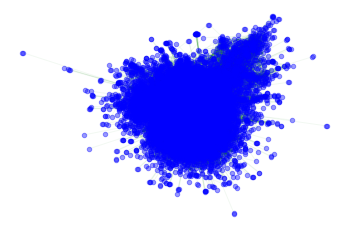

In [67]:
import networkx as nx
from fa2 import ForceAtlas2
import matplotlib.pyplot as plt

# G = nx.random_geometric_graph(400, 0.2)

forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=20,
                        strongGravityMode=False,
                        gravity=0.5,

                        # Log
                        verbose=True)

positions = forceatlas2.forceatlas2_networkx_layout(G_nx, pos=None, iterations=2000)
nx.draw_networkx_nodes(G_nx, positions, node_size=20, with_labels=False, node_color="blue", alpha=0.4)
nx.draw_networkx_edges(G_nx, positions, edge_color="green", alpha=0.05)
plt.axis('off')
plt.show()


### Convert "positions" to "certesian"

In [68]:
certesian = [{'node':i,'x': float(positions[n][0]),'y': float(positions[n][1])}for i, n in enumerate(positions)]

In [70]:
ncx_from_x=ndex2.create_nice_cx_from_networkx(G_nx)

for i in range(g.vcount()):
    ncx_from_x.set_node_attribute(i, "closeness", g_closeness[i])
    ncx_from_x.set_node_attribute(i, "degree", g_degree[i])
    ncx_from_x.set_node_attribute(i, "pagerank", g_pagerank[i])
    ncx_from_x.set_node_attribute(i, "betweenness", g_vs_betweenness[i])
    ncx_from_x.set_node_attribute(i, "community.greedy", v_community_greedy[i])
    ncx_from_x.set_node_attribute(i, "community.leading", v_community_leading[i])
    ncx_from_x.set_node_attribute(i, "community.label.propagation", v_community_label_propagation[i])
    ncx_from_x.set_node_attribute(i, "colors.community.greedy", communityToColors(v_community_greedy)[i])
    ncx_from_x.set_node_attribute(i, "colors.community.leading", communityToColors(v_community_leading)[i])
    ncx_from_x.set_node_attribute(i, "colors.community.label.propagation", communityToColors(v_community_label_propagation)[i])
 


for i in range(g.ecount()):
    ncx_from_x.set_edge_attribute(i, "betweenness.edge", g_es_betweenness[i])
    ncx_from_x.set_edge_attribute(i, "community.greedy", e_commnity_greedy[i])
    ncx_from_x.set_edge_attribute(i, "community.leading", e_commnity_leading[i])
    ncx_from_x.set_edge_attribute(i, "community.label.propagation", e_community_label_propagation[i])
    ncx_from_x.set_edge_attribute(i, "colors.community.greedy", communityToColors(e_commnity_greedy)[i])
    ncx_from_x.set_edge_attribute(i, "colors.community.leading", communityToColors(e_commnity_leading)[i])
    ncx_from_x.set_edge_attribute(i, "colors.community.label.propagation", communityToColors(e_community_label_propagation)[i])
    


### Apply "certesian" to NiceCX

In [71]:
print(type(ncx_from_x.VISUAL_PROPERTIES))
# ncx_from_x.set_opaque_aspect("VISUAL_PROPERTIES",colors)

ncx_from_x.apply_template('public.ndexbio.org','92084251-c859-11e9-aa81-0ac135e8bacf')

ncx_from_x.set_opaque_aspect("cartesianLayout", certesian)

<class 'str'>


## Send to Cytoscape

In [ ]:
import json
with open('py3sample_nx.cx', 'w') as outfile:
    json.dump(ncx_from_x.to_cx(), outfile)

In [ ]:
import requests

In [ ]:
url = 'http://'+POST+':1234/v1/networks'
response1 = requests.post(url, data=json.dumps(ncx_from_x.to_cx()))
response1.text

##  upload the network

In [72]:
my_account="am"
my_password="ndexpassword"
my_server="http://public.ndexbio.org"

if my_account == 'enter your username here':
    print('*******WARNING!!!!*******')
    print('Please change the username and password before proceeding')
else:
    try:
        my_ndex=nc.Ndex2(my_server, my_account, my_password)
        my_ndex.update_status()
        print("Success.  Please continue.")
    except Exception as inst:
        print("Could not access account %s with password %s" % (my_account, my_password))
        print(inst.args)

Success.  Please continue.


In [73]:
upload_message=ncx_from_x.upload_to(my_server, my_account, my_password)
print(upload_message)

Generating CX
http://public.ndexbio.org/v2/network/7c06fa91-c87d-11e9-aa81-0ac135e8bacf


# Step 4: Send data to Cytoscape

## BuildStyle

In [ ]:
def BuildStyle(style_name, g, colors, community):
    # Prepare Defaults
    def_node_border_widh = {"visualProperty":"NODE_BORDER_WIDTH",
                           "value":0}
    def_node_transparency = {"visualProperty":"NODE_TRANSPARENCY",
                            "value":230}
    def_edge_transparency = {"visualProperty":"EDGE_TRANSPARENCY",
                            "value":120}
    def_edge_widh = {"visualProperty":"EDGE_WIDTH",
                    "value":2}
    def_network_background = {"visualProperty":"NETWORK_BACKGROUND_PAINT",
                             "value":"black"}
    
    defaults = [def_node_border_widh,
               def_node_transparency,
               def_edge_transparency,
               def_edge_widh,
               def_network_background]
    
    #Mappings
    mapping = []
    
    #Color mappings
    node_fill_color = {"mappingType":"passthrough",
                       "mappingColumns":colors,
                       "mappingColumnType":"String",
                       "visualProperty":"NODE_FILL_COLOR"}
    
    edge_color = {"mappingType":"passthrough",
                  "mappingColumn":colors,
                  "mappingColumnType":"String",
                  "visualProperty":"EDGE_STROKE_UNSELECTED_PAINT"}
    
    #Node Size Mapping
    min_betweenness = min(g.vs.betweenness())
    max_betweenness = max(g.vs.betweenness())
    
    point1 = {"value":min_betweenness,
              "lesser":"5.0",
              "equal":"5.0",
              "greater":"5.0"}
    
    point2 = {"value":max_betweenness,
              "lesser":"100.0",
              "equal":"100.0",
              "greater":"100.0"}
    
    node_size_continuous_points = [point1,point2]
    
    node_size = {"mappingType":"continuous",
                 "mappingColumn":"betweenness",
                 "mappingColumnType":"Double",
                 "visualProperty":"NODE_SIZE",
                 "points":node_size_continuous_points}
    
    edge_trans_point = {"value":1.0,
                        "lesser":"40",
                        "equal":"200",
                        "greater":"200"}
    edge_trans_continuous_points = [edge_trans_point]
    
    edge_trans = {"mappingType":"continuous",
                 "mappingColumn":community,
                 "mappingColumnType":"Double",
                 "visualProperty":"EDGE_TRANSPARENCY",
                 "points":edge_trans_continuous_points}
    
    mappings = [node_fill_color, edge_color, node_size, edge_trans]
    
    style = {"title":style_name, "default":defaults, "mapping":mappings}
    
    return style

In [ ]:
style=BuildStyle('greedy',g,colors="vs['color']",community="community_fastgreedy().as_clustering().membership")

In [ ]:
import json

In [ ]:
a = json.dumps(style)
b = py2cytoscape.util.from_igraph(g)

In [ ]:
url='http://localhost:1234/v1/styles'
response1 = requests.post(url, a)
response1.text

In [ ]:
def BuildStyle_simple(style_name, g, colors):
    # Prepare Defaults
    def_node_border_widh = {"visualProperty":"NODE_BORDER_WIDTH",
                           "value":0}
    def_edge_widh = {"visualProperty":"EDGE_WIDTH",
                    "value":2}
    def_network_background = {"visualProperty":"NETWORK_BACKGROUND_PAINT",
                             "value":"black"}
    
    defaults = [def_node_border_widh,
               def_network_background]
    
    #Mappings
    mapping = []
    
    #Color mappings
    node_fill_color = {"mappingType":"passthrough",
                       "mappingColumns":colors,
                       "mappingColumnType":"String",
                       "visualProperty":"NODE_FILL_COLOR"}
    
    edge_color = {"mappingType":"passthrough",
                  "mappingColumn":colors,
                  "mappingColumnType":"String",
                  "visualProperty":"EDGE_STROKE_UNSELECTED_PAINT"}
    node_label = {"mappingType":"passthrough",
                 "mappingColumn":"name",
                 "mappingColumnType":"String",
                 "visualProperty":"NODE_LABEL"}
    
    mappings = [node_fill_color, edge_color, node_label]
    
    style = {"title":style_name, "default":defaults, "mapping":mappings}
    
    return style

In [ ]:
style=BuildStyle_simple('greedy',g,colors="vs['color']")